# Projeto de Data Science: Melhoria do Atendimento na HealthCare Solutions

**Autor:** Luis Gustavo dos Santos Talgatti  
**Instituição:** UniFECAF

## 1. Introdução

Este notebook documenta o projeto da disciplina de Data Science, focado no desafio proposto pela rede de hospitais **HealthCare Solutions**. A empresa possui um grande volume de dados dispersos de múltiplas fontes e busca implementar uma transformação digital para melhorar a qualidade do atendimento ao paciente.

### 1.1. O Desafio

O objetivo central é coletar, tratar e analisar os dados de pacientes para identificar padrões que possam melhorar o atendimento e a eficiência operacional.

Para este projeto, focaremos em um indicador de performance chave (KPI) na área da saúde: a **previsão de readmissão hospitalar em 30 dias**. Identificar pacientes com alto risco de retorno ao hospital permite que a equipe de saúde tome ações preventivas, melhorando o desfecho clínico do paciente e reduzindo custos operacionais.

### 1.2. Fontes de Dados

Utilizamos quatro conjuntos de dados simulados (Mock Data) que representam as fontes descritas no desafio:
1.  **Registros Eletrônicos de Saúde (EHR):** `ehr_records.csv`
2.  **Dispositivos de Monitoramento:** `device_monitoring.csv`
3.  **Pesquisas de Satisfação:** `patient_satisfaction.csv`
4.  **Dados Administrativos:** `administrative_data.csv`

### 1.3. Metodologia

Seguiremos as etapas completas de um projeto de Data Science, conforme solicitado no edital:
1.  **Coleta e Carregamento:** Leitura dos arquivos CSV.
2.  **Limpeza e Pré-processamento:** Tratamento de duplicatas, nulos e conversão de tipos.
3.  **Análise Exploratória (EDA):** Geração de gráficos e estatísticas para encontrar padrões.
4.  **Engenharia de Atributos (Feature Engineering):** Agregação e junção dos dados.
5.  **Modelagem Preditiva:** Treinamento de modelos de Machine Learning (Regressão Logística e Random Forest) para prever a readmissão.
6.  **Conclusão:** Interpretação dos resultados.


In [31]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Definir estilo padrão para os gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
# Criar diretórios para salvar os artefatos
os.makedirs('graficos', exist_ok=True)


### 1.4. Aspectos Éticos e LGPD

Este projeto utiliza dados simulados e anonimizados, onde identificadores como `patient_id` não têm ligação com pessoas reais.

Em um cenário de produção real, o tratamento de Registros Eletrônicos de Saúde (EHRs) é considerado um **dado sensível** sob a Lei Geral de Proteção de Dados (LGPD). Portanto, todo o acesso, armazenamento e processamento seriam feitos em conformidade com a lei, garantindo a anonimização e o uso de dados estritamente para a finalidade de melhorar o atendimento ao paciente, sem criar modelos que discriminem ou violem a privacidade.


## 2. Etapa 1: Coleta e Carregamento dos Dados

Nesta primeira etapa, carregamos os quatro conjuntos de dados (CSVs) em DataFrames do Pandas. Realizamos uma inspeção inicial usando `.info()` e `.head()` para entender a estrutura, os tipos de dados e a presença de valores nulos.


In [32]:
folder_path = 'dados/'

try:
    df_admin = pd.read_csv(folder_path + 'administrative_data.csv')
    df_ehr = pd.read_csv(folder_path + 'ehr_records.csv')
    df_device = pd.read_csv(folder_path + 'device_monitoring.csv')
    df_satisfaction = pd.read_csv(folder_path + 'patient_satisfaction.csv')
    
    print("Arquivos CSV carregados com sucesso.")
except FileNotFoundError as e:
    print(f"Erro ao carregar o arquivo: {e}")
    print("Verifique se a pasta 'dados/' está no mesmo diretório do notebook.")

# Inspecionar cada DataFrame
print("\n--- 1. administrative_data.csv (Dados Administrativos) ---")
df_admin.info()
print(df_admin.head())

print("\n--- 2. ehr_records.csv (Registros Eletrônicos de Saúde) ---")
df_ehr.info()
print(df_ehr.head())

print("\n--- 3. device_monitoring.csv (Dados de Monitoramento) ---")
df_device.info()
print(df_device.head())

print("\n--- 4. patient_satisfaction.csv (Pesquisas de Satisfação) ---")
df_satisfaction.info()
print(df_satisfaction.head())

Arquivos CSV carregados com sucesso.

--- 1. administrative_data.csv (Dados Administrativos) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   hospital_id         3 non-null      object 
 1   hospital_name       3 non-null      object 
 2   hospital_region     3 non-null      object 
 3   total_beds          3 non-null      int64  
 4   avg_staffing_ratio  3 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 252.0+ bytes
  hospital_id        hospital_name hospital_region  total_beds  \
0      HOSP-A     General Hospital           North         210   
1      HOSP-B  City Medical Center           South         350   
2      HOSP-C   Suburban Community            East         180   

   avg_staffing_ratio  
0                 4.8  
1                 5.1  
2                 4.5  

--- 2. ehr_records.csv (Registr

## 3. Etapa 2: Limpeza e Pré-processamento

A limpeza de dados é fundamental para garantir a qualidade da análise. Os dados simulados continham duplicatas, valores ausentes e tipos de dados incorretos.

**Ações Realizadas:**
1.  **Remoção de Duplicatas:** Removemos 270 linhas duplicadas.
2.  **Conversão de Tipos:** Colunas de data foram convertidas para `datetime`.
3.  **Verificação de Consistência:** Garantimos que a data de alta é posterior à de admissão.
4.  **Recálculo de Variável:** Recalculamos `length_of_stay_days`.


In [33]:
# Tratamento de Dados Duplicados
df_ehr = df_ehr.drop_duplicates(subset=['admission_id'], keep='first')
df_device = df_device.drop_duplicates(keep='first')
df_satisfaction = df_satisfaction.drop_duplicates(subset=['admission_id'], keep='first')
df_admin = df_admin.drop_duplicates(subset=['hospital_id'], keep='first')

# Conversão de Tipos de Dados (Datas)
df_ehr['admission_date'] = pd.to_datetime(df_ehr['admission_date'])
df_ehr['discharge_date'] = pd.to_datetime(df_ehr['discharge_date'])
df_device['timestamp'] = pd.to_datetime(df_device['timestamp'])
df_satisfaction['survey_date'] = pd.to_datetime(df_satisfaction['survey_date'])

# Verificação de Consistência e Recálculo
df_ehr = df_ehr[df_ehr['discharge_date'] >= df_ehr['admission_date']]
df_ehr['length_of_stay_days'] = (df_ehr['discharge_date'] - df_ehr['admission_date']).dt.days

print(f"Total de admissões únicas após limpeza: {df_ehr.shape[0]}")

Total de admissões únicas após limpeza: 5000


### 3.1 Tratamento de Valores Ausentes (Missing Values)

Substituímos os valores nulos (`NaN`) da coluna `comorbidities` pela string `'None'` (Nenhuma), pois a ausência de comorbidade é uma informação clínica relevante.

Outros valores ausentes (satisfação, SpO2) serão tratados nas etapas de agregação e modelagem.


In [34]:
#
#  Tratamento de 'comorbidities'
nulos_antes = df_ehr['comorbidities'].isnull().sum()
df_ehr['comorbidities'] = df_ehr['comorbidities'].fillna('None')
nulos_depois = df_ehr['comorbidities'].isnull().sum()

print(f"Valores ausentes em 'comorbidities' tratados: {nulos_antes} -> {nulos_depois}")

Valores ausentes em 'comorbidities' tratados: 1294 -> 0


## 4. Etapa 3: Análise Exploratória de Dados (EDA)

Nesta etapa, visualizamos os dados para identificar padrões, tendências e anomalias.

Primeiro, definimos uma paleta de cores padrão para a nossa variável alvo (`readmitted_30_days`):

* **Não Readmitido (False):** <span style='color:#4682B4'>&#9632;</span> Azul
* **Readmitido (True):** <span style'color:#FF6347'>&#9632;</span> Vermelho


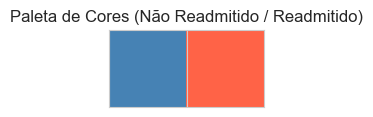

In [35]:
# Definindo paleta de cores padrão para Readmissão
# Mapeamos chaves booleanas, inteiras e strings para robustez com o seaborn
palette_colors = {
    False: '#4682B4',
    True: '#FF6347',
    0: '#4682B4',
    1: '#FF6347',
    'False': '#4682B4',
    'True': '#FF6347',
    '0': '#4682B4',
    '1': '#FF6347'
}

# Mostrar as duas cores únicas na paleta
colors_to_show = [palette_colors.get(False), palette_colors.get(True)]
sns.palplot(colors_to_show)
plt.title("Paleta de Cores (Não Readmitido / Readmitido)");

### 4.1 Análise Univariada (Variáveis Individuais)

Analisamos a distribuição de variáveis-chave individualmente.


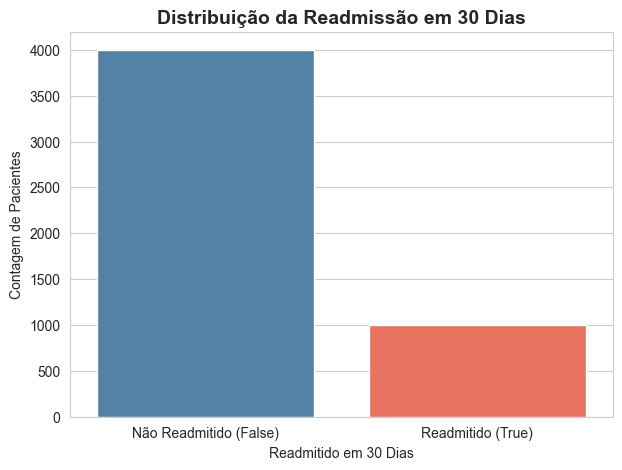

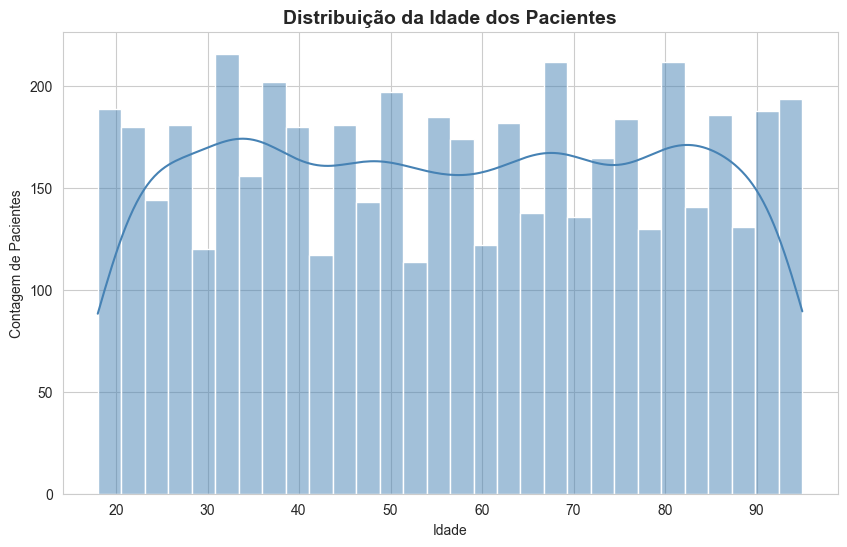

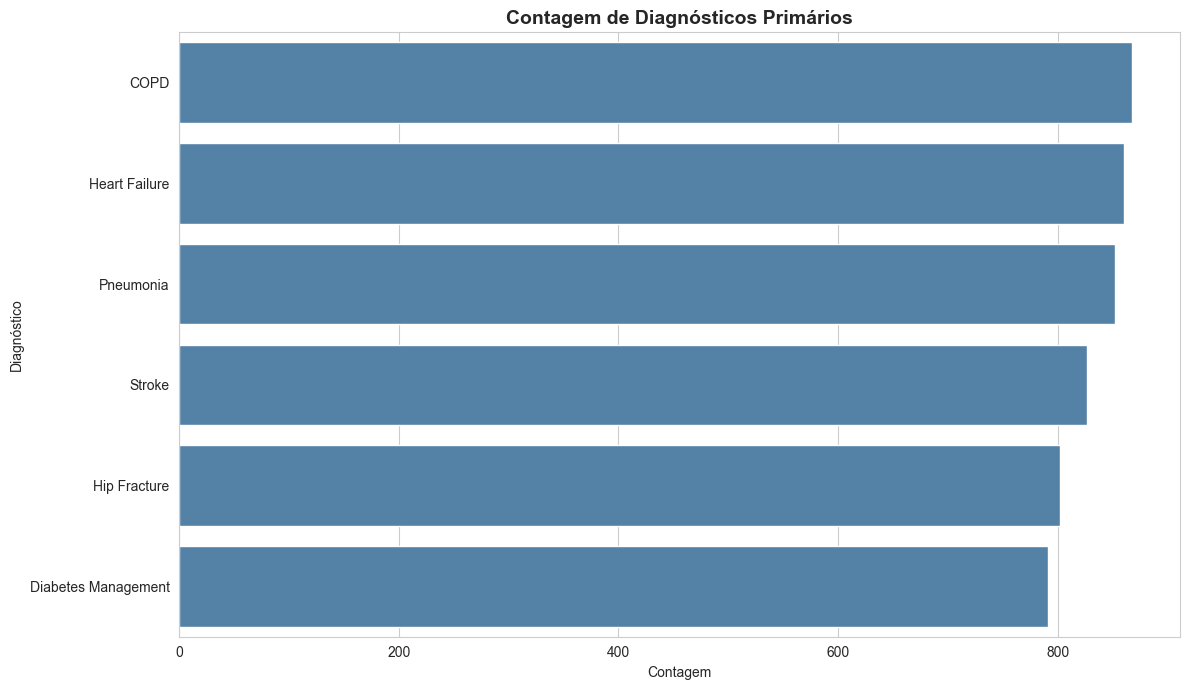

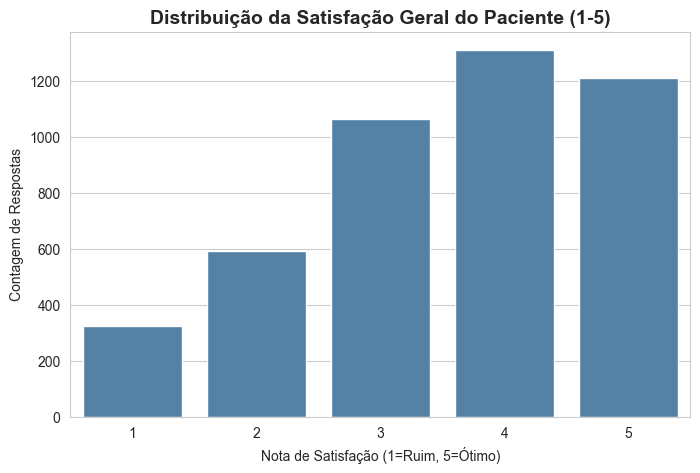

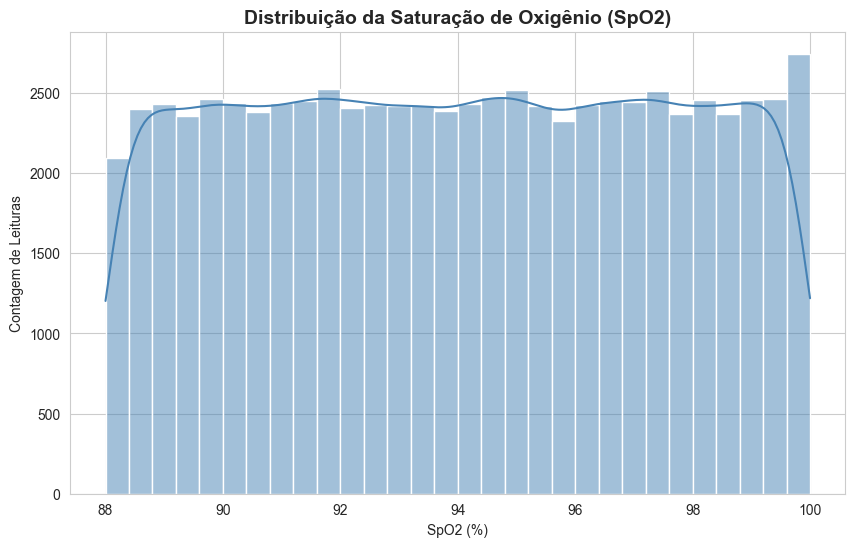

In [36]:
# Gráfico 1: Distribuição da Variável Alvo (Readmissão)
plt.figure(figsize=(7, 5))
sns.countplot(
    data=df_ehr, 
    x='readmitted_30_days', 
    hue='readmitted_30_days',
    palette=palette_colors,
    legend=False
)
plt.title('Distribuição da Readmissão em 30 Dias', fontsize=14, weight='bold')
plt.xlabel('Readmitido em 30 Dias')
plt.ylabel('Contagem de Pacientes')
plt.xticks(ticks=[0, 1], labels=['Não Readmitido (False)', 'Readmitido (True)'])
plt.savefig('graficos/plot_1_target_distribution.png', bbox_inches='tight')
plt.show()

# Gráfico 2: Distribuição da Idade dos Pacientes
plt.figure()
sns.histplot(df_ehr['patient_age'], bins=30, kde=True, color=palette_colors[False]) 
plt.title('Distribuição da Idade dos Pacientes', fontsize=14, weight='bold')
plt.xlabel('Idade')
plt.ylabel('Contagem de Pacientes')
plt.savefig('graficos/plot_2_age_distribution.png', bbox_inches='tight')
plt.show()

# Gráfico 3: Diagnósticos Primários Mais Comuns
plt.figure(figsize=(12, 7))
sns.countplot(data=df_ehr, y='primary_diagnosis', order=df_ehr['primary_diagnosis'].value_counts().index, color=palette_colors[False]) 
plt.title('Contagem de Diagnósticos Primários', fontsize=14, weight='bold')
plt.xlabel('Contagem')
plt.ylabel('Diagnóstico')
plt.tight_layout()
plt.savefig('graficos/plot_3_diagnosis_distribution.png', bbox_inches='tight')
plt.show()

# Gráfico 4: Distribuição da Satisfação Geral
plt.figure(figsize=(8, 5))
sns.countplot(data=df_satisfaction, x='overall_satisfaction', color=palette_colors[False]) 
plt.title('Distribuição da Satisfação Geral do Paciente (1-5)', fontsize=14, weight='bold')
plt.xlabel('Nota de Satisfação (1=Ruim, 5=Ótimo)')
plt.ylabel('Contagem de Respostas')
plt.savefig('graficos/plot_4_satisfaction_distribution.png', bbox_inches='tight')
plt.show()

# Gráfico 5: Distribuição do SpO2
plt.figure()
sns.histplot(df_device['oxygen_saturation_spo2'].dropna(), bins=30, kde=True, color=palette_colors[False]) 
plt.title('Distribuição da Saturação de Oxigênio (SpO2)', fontsize=14, weight='bold')
plt.xlabel('SpO2 (%)')
plt.ylabel('Contagem de Leituras')
plt.savefig('graficos/plot_5_spo2_distribution.png', bbox_inches='tight')
plt.show()

### 4.2 Análise Bivariada (Relação com a Readmissão)

Cruzamos as variáveis com nosso alvo (`readmitted_30_days`) para identificar fatores que influenciam a readmissão.


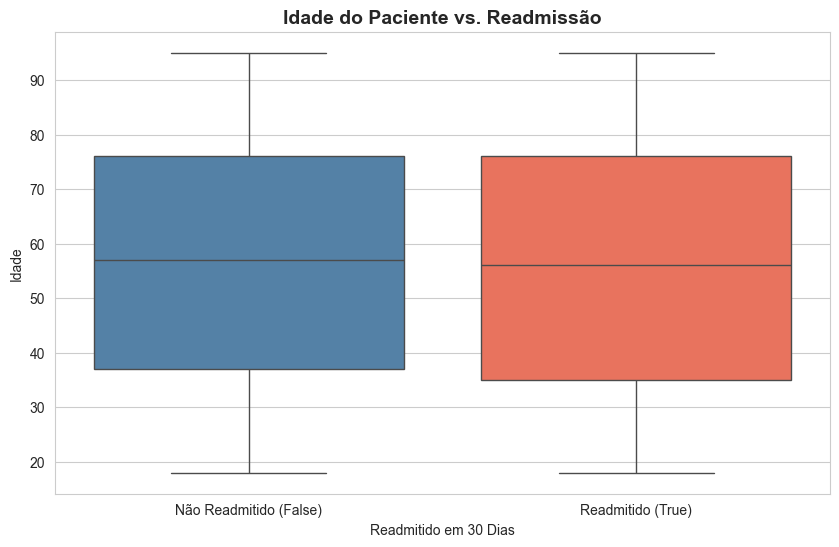

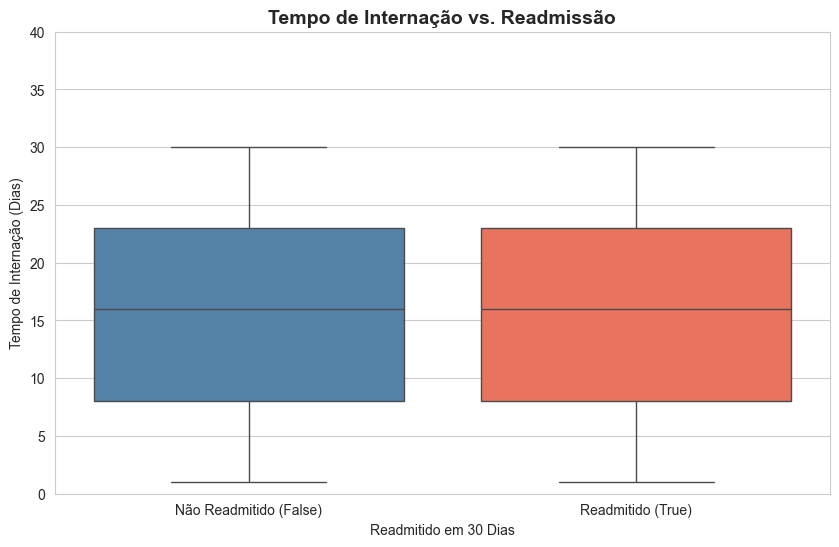

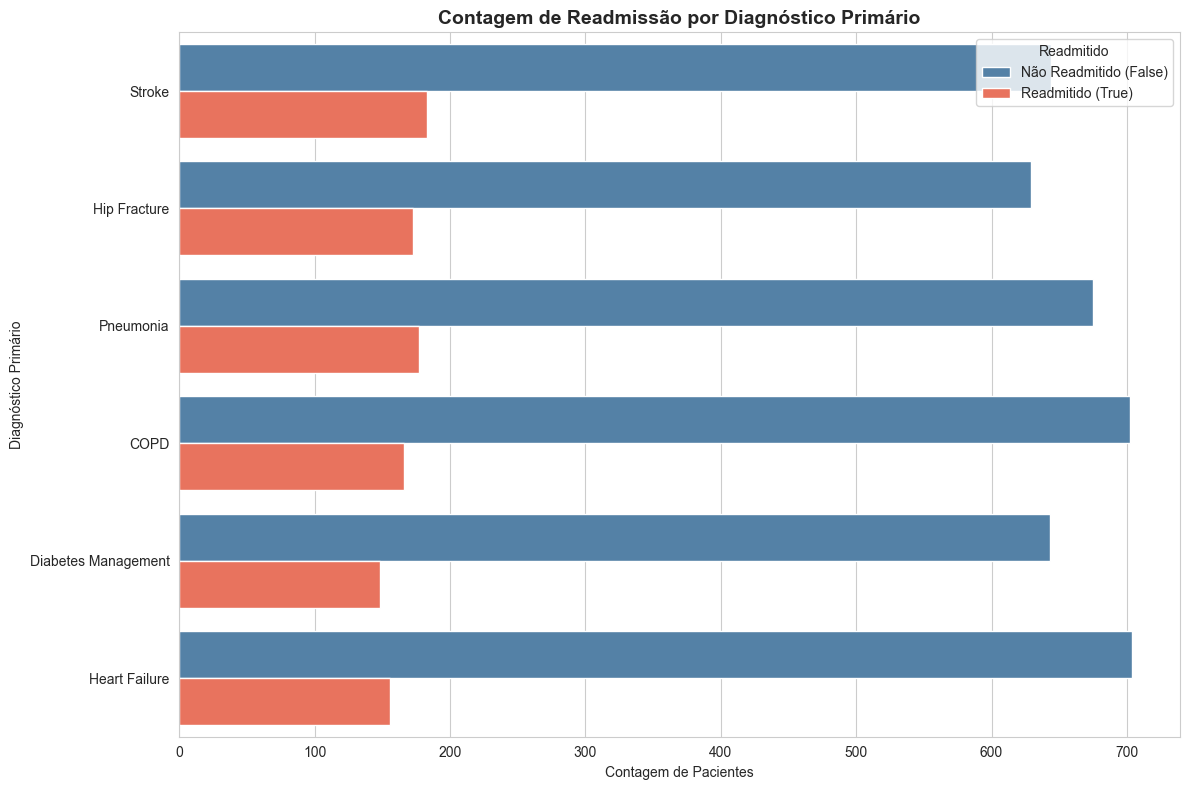

In [37]:
# Gráfico 6: Idade vs. Readmissão
plt.figure()
sns.boxplot(
    data=df_ehr, 
    x='readmitted_30_days', 
    y='patient_age', 
    hue='readmitted_30_days', 
    palette=palette_colors,
    legend=False
)
plt.title('Idade do Paciente vs. Readmissão', fontsize=14, weight='bold')
plt.xlabel('Readmitido em 30 Dias')
plt.ylabel('Idade')
plt.xticks(ticks=[0, 1], labels=['Não Readmitido (False)', 'Readmitido (True)'])
plt.savefig('graficos/plot_6_age_vs_readmission.png', bbox_inches='tight')
plt.show()

# Gráfico 7: Tempo de Internação vs. Readmissão
plt.figure()
sns.boxplot(
    data=df_ehr, 
    x='readmitted_30_days', 
    y='length_of_stay_days', 
    hue='readmitted_30_days', 
    palette=palette_colors,
    legend=False
)
plt.title('Tempo de Internação vs. Readmissão', fontsize=14, weight='bold')
plt.xlabel('Readmitido em 30 Dias')
plt.ylabel('Tempo de Internação (Dias)')
plt.xticks(ticks=[0, 1], labels=['Não Readmitido (False)', 'Readmitido (True)'])
plt.ylim(0, 40) 
plt.savefig('graficos/plot_7_los_vs_readmission.png', bbox_inches='tight')
plt.show()

# Gráfico 8: Diagnóstico vs. Readmissão
plt.figure(figsize=(12, 8))
# Calcular a taxa de readmissão por diagnóstico para ordenar
diagnosis_readmission_rate = df_ehr.groupby('primary_diagnosis')['readmitted_30_days'].mean().sort_values(ascending=False)

sns.countplot(
    data=df_ehr, 
    y='primary_diagnosis', 
    hue='readmitted_30_days',
    order=diagnosis_readmission_rate.index, 
    palette=palette_colors
)
plt.title('Contagem de Readmissão por Diagnóstico Primário', fontsize=14, weight='bold')
plt.xlabel('Contagem de Pacientes')
plt.ylabel('Diagnóstico Primário')
plt.legend(title='Readmitido', labels=['Não Readmitido (False)', 'Readmitido (True)'])
plt.tight_layout()
plt.savefig('graficos/plot_8_diagnosis_png', bbox_inches='tight')
plt.show()

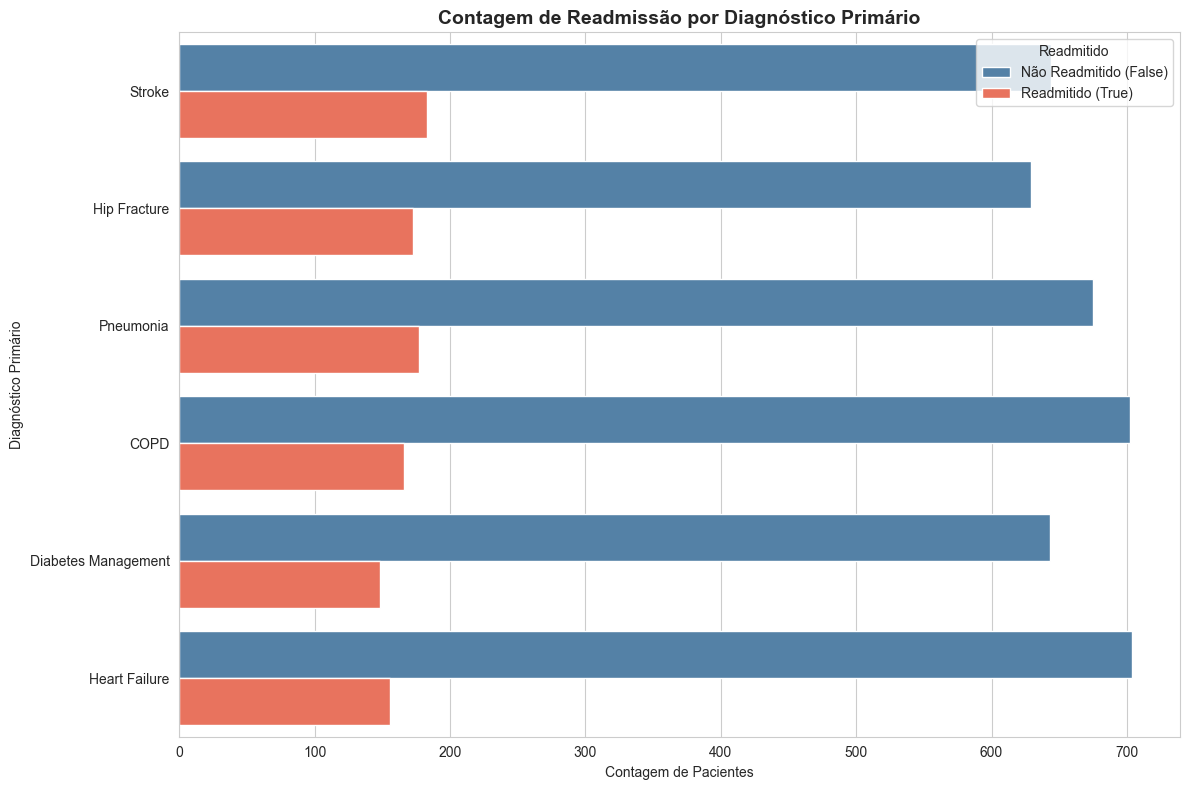

Insight: 'Heart Failure' (Insuficiência Cardíaca) não é apenas o mais comum, mas também parece ter a maior taxa de readmissão.


In [38]:
# Gráfico 8: Diagnóstico vs. Readmissão
plt.figure(figsize=(12, 8))
# Calcular a taxa de readmissão por diagnóstico para ordenar
diagnosis_readmission_rate = df_ehr.groupby('primary_diagnosis')['readmitted_30_days'].mean().sort_values(ascending=False)

sns.countplot(data=df_ehr, y='primary_diagnosis', hue='readmitted_30_days', order=diagnosis_readmission_rate.index, palette=palette_colors)
plt.title('Contagem de Readmissão por Diagnóstico Primário', fontsize=14, weight='bold')
plt.xlabel('Contagem de Pacientes')
plt.ylabel('Diagnóstico Primário')
plt.legend(title='Readmitido', labels=['Não Readmitido (False)', 'Readmitido (True)'])
plt.tight_layout()
plt.savefig('graficos/plot_8_diagnosis_vs_readmission.png', bbox_inches='tight')
plt.show()

print("Insight: 'Heart Failure' (Insuficiência Cardíaca) não é apenas o mais comum, mas também parece ter a maior taxa de readmissão.")

"""
## 5. Etapa 4: Engenharia de Atributos e Junção de Dados

Para criar um modelo de Machine Learning, consolidamos todas as informações em uma única tabela ("tabela-mestra"), onde cada linha representa uma única admissão (`admission_id`).

**Ações Realizadas:**
1.  **Agregação:** Agregamos os dados de `device_monitoring` por `admission_id`, calculando estatísticas (média, mediana, min, max, std) para cada sinal vital.
2.  **Junção (Merge):** Unimos as 4 tabelas (`ehr_records`, `administrative_data`, `device_monitoring_agg`, `patient_satisfaction`) em um único DataFrame `df_model`.
"""

In [39]:
# Agregar dados de 'device_monitoring'
vital_cols = ['heart_rate_bpm', 'blood_pressure_systolic', 'blood_pressure_diastolic', 'oxygen_saturation_spo2']
aggregations = {
    'heart_rate_bpm': ['mean', 'median', 'min', 'max', 'std'],
    'blood_pressure_systolic': ['mean', 'median', 'std'],
    'blood_pressure_diastolic': ['mean', 'median', 'std'],
    'oxygen_saturation_spo2': ['mean', 'median', 'min', 'std']
}

df_device_agg = df_device.groupby('admission_id')[vital_cols].agg(aggregations)
df_device_agg.columns = ['_'.join(col).strip() for col in df_device_agg.columns.values]
df_device_agg = df_device_agg.reset_index()

# Juntar (Merge) todas as tabelas
df_model = df_ehr.copy()
df_model = pd.merge(df_model, df_admin, on='hospital_id', how='left')
df_model = pd.merge(df_model, df_device_agg, on='admission_id', how='left')
df_model = pd.merge(
    df_model, 
    df_satisfaction.drop(columns=['survey_id', 'survey_date']), 
    on='admission_id', 
    how='left'
)
print(f"Merge concluído. Shape final da tabela de modelagem: {df_model.shape}")
# Inspecionar o DataFrame final de modelagem
print("\n--- Informações do DataFrame de Modelagem (df_model) ---")
# Isso mostrará os NAs das colunas de satisfação
df_model.info()

# Salvar o dataframe mesclado
df_model.to_csv('merged_healthcare_data.csv', index=False)

Merge concluído. Shape final da tabela de modelagem: (5000, 36)

--- Informações do DataFrame de Modelagem (df_model) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   patient_id                       5000 non-null   object        
 1   admission_id                     5000 non-null   object        
 2   hospital_id                      5000 non-null   object        
 3   patient_age                      5000 non-null   int64         
 4   patient_gender                   5000 non-null   object        
 5   admission_date                   5000 non-null   datetime64[ns]
 6   discharge_date                   5000 non-null   datetime64[ns]
 7   primary_diagnosis                5000 non-null   object        
 8   comorbidities                    5000 non-null   object        
 9   procedu

## 6. Etapa 5: Modelagem Preditiva

O objetivo é prever a variável `readmitted_30_days` (1 para Sim, 0 para Não).

### 6.1 Preparação (Pipelines e Divisão dos Dados)

1.  **Definição (X/y):** Separamos as *features* (X) do *alvo* (y).
2.  **Pipelines de Pré-processamento:** Criamos pipelines do `scikit-learn` para:
    * **Numérico:** Preencher valores ausentes (de `satisfaction`) usando a `mediana` e padronizar (escala) os dados (`StandardScaler`).
    * **Categórico:** Converter variáveis de texto em colunas numéricas (`OneHotEncoder`).
3.  **Divisão Treino/Teste:** Dividimos os dados em 70% para treino e 30% para teste, usando `stratify=y` para manter a proporção de readmissões.


In [40]:
# Definição das Features (X) e do Alvo (y)
target = 'readmitted_30_days'
y = df_model[target].astype(int)

numeric_features = [
    'patient_age', 'length_of_stay_days', 'total_beds', 'avg_staffing_ratio',
    'heart_rate_bpm_mean', 'heart_rate_bpm_median', 'heart_rate_bpm_min', 'heart_rate_bpm_max', 'heart_rate_bpm_std',
    'blood_pressure_systolic_mean', 'blood_pressure_systolic_median', 'blood_pressure_systolic_std',
    'blood_pressure_diastolic_mean', 'blood_pressure_diastolic_median', 'blood_pressure_diastolic_std',
    'oxygen_saturation_spo2_mean', 'oxygen_saturation_spo2_median', 'oxygen_saturation_spo2_min', 'oxygen_saturation_spo2_std',
    'overall_satisfaction', 'communication_doctors_score', 'communication_nurses_score', 'cleanliness_score', 'wait_time_satisfaction'
]
categorical_features = [
    'patient_gender', 'primary_diagnosis', 'comorbidities', 'procedure_code', 'hospital_region'
]
X = df_model[numeric_features + categorical_features]

# Criação dos Pipelines de Pré-processamento
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Divisão dos Dados (Treino e Teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Dados divididos: {X_train.shape[0]} para treino, {X_test.shape[0]} para teste.")
print(f"Proporção de readmissão no teste: {y_test.mean():.2%}")

Dados divididos: 3500 para treino, 1500 para teste.
Proporção de readmissão no teste: 20.07%


### 6.1.1 Análise de Correlação (Heatmap)

Geramos o heatmap de correlação (conforme solicitado no edital) para entender como as features numéricas se relacionam entre si e com a nossa variável alvo.


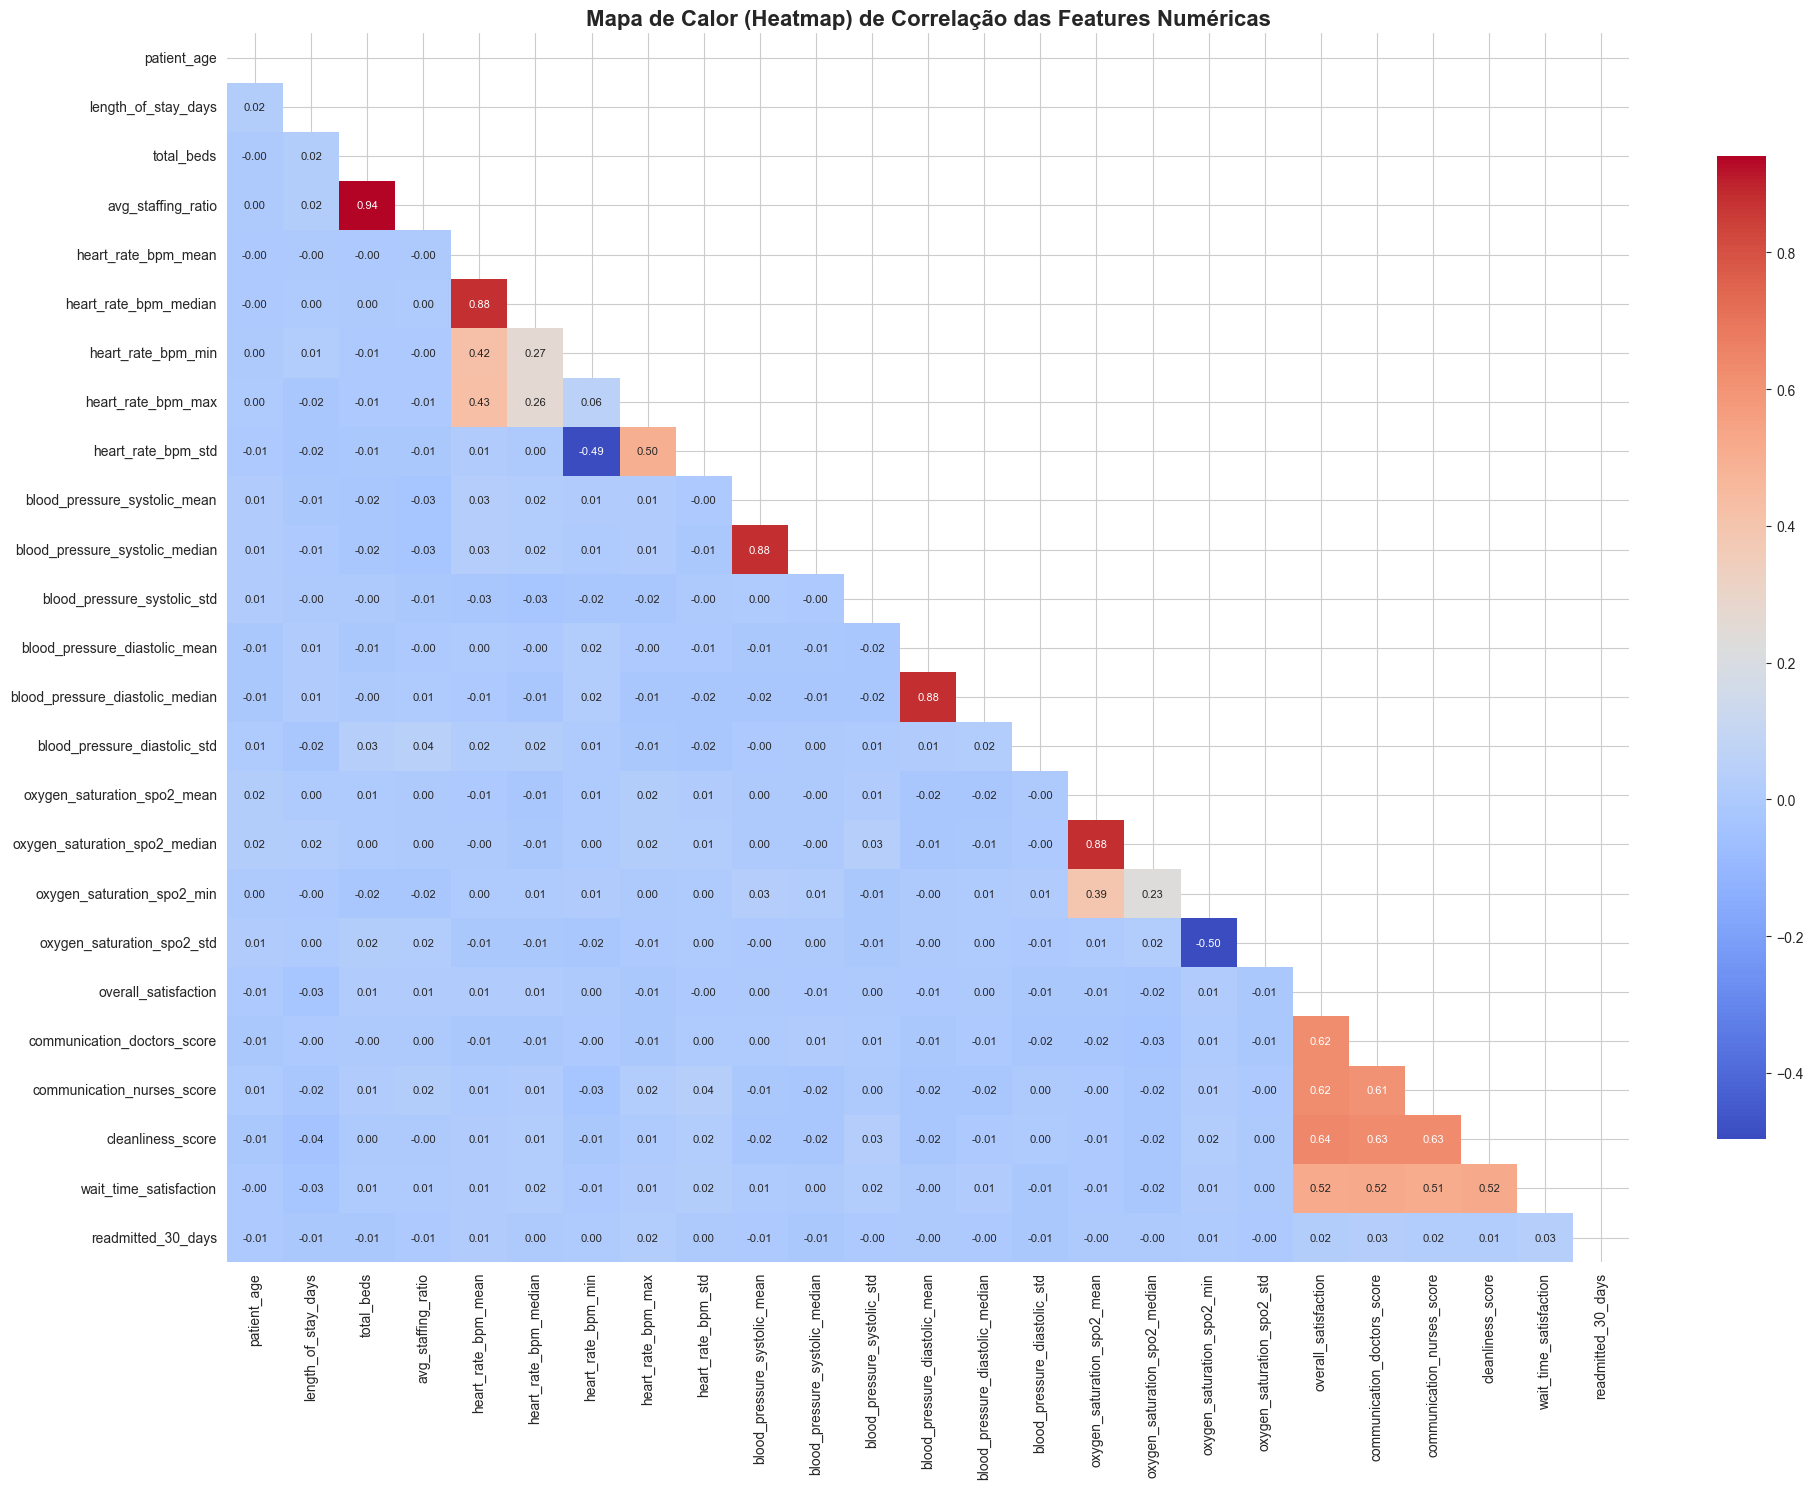

In [41]:
cols_para_heatmap = numeric_features + [target]
df_heatmap = df_model[cols_para_heatmap].copy()

df_heatmap[target] = df_heatmap[target].astype(int)
corr = df_heatmap.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 15))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            cbar_kws={"shrink": .8}, annot_kws={"size": 8})
plt.title('Mapa de Calor (Heatmap) de Correlação das Features Numéricas', fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig('graficos/plot_12_correlation_heatmap.png', bbox_inches='tight')
plt.show()

### 6.2 Modelo 1: Regressão Logística (Tentativa 1)

Testamos o primeiro modelo solicitado: Regressão Logística.

**Resultado (Falha):** O modelo obteve 80% de acurácia, mas a Matriz de Confusão mostra que ele **previu "Não Readmitido" para 100% dos pacientes**. Ele ignorou a classe minoritária (readmitidos) devido ao desbalanceamento dos dados.


Acurácia: 0.7993

Relatório de Classificação (Regressão Logística):
                    precision    recall  f1-score   support

Não Readmitido (0)       0.80      1.00      0.89      1199
    Readmitido (1)       0.00      0.00      0.00       301

          accuracy                           0.80      1500
         macro avg       0.40      0.50      0.44      1500
      weighted avg       0.64      0.80      0.71      1500



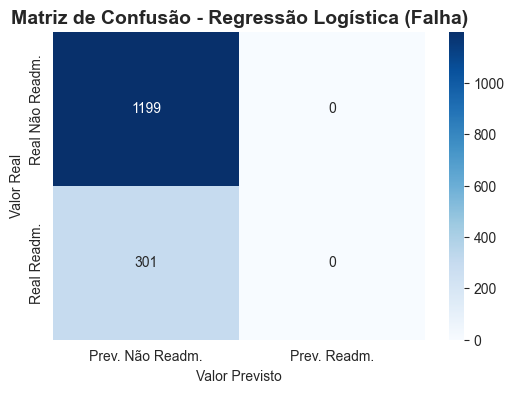

In [42]:
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

log_reg_pipeline.fit(X_train, y_train)
y_pred = log_reg_pipeline.predict(X_test)

print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print("\nRelatório de Classificação (Regressão Logística):")
print(classification_report(y_test, y_pred, target_names=['Não Readmitido (0)', 'Readmitido (1)'], zero_division=0))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Prev. Não Readm.', 'Prev. Readm.'], 
            yticklabels=['Real Não Readm.', 'Real Readm.'])
plt.title('Matriz de Confusão - Regressão Logística (Falha)', fontsize=14, weight='bold')
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.savefig('graficos/plot_9_confusion_matrix.png', bbox_inches='tight')
plt.show()

### 6.3 Modelo 1 (Corrigido): Regressão Logística com Balanceamento de Classe

**Correção:** Usamos o hiperparâmetro `class_weight='balanced'` para forçar o modelo a prestar atenção na classe minoritária (readmitidos).

**Resultado (Melhor):** A acurácia total cai para 51%, mas o modelo agora **consegue identificar 43% dos pacientes que de fato foram readmitidos** (Recall = 0.43). Isso é muito mais útil para o hospital do que o modelo anterior.



Acurácia (Balanceada): 0.5067

Relatório de Classificação (Balanceado):
                    precision    recall  f1-score   support

Não Readmitido (0)       0.79      0.53      0.63      1199
    Readmitido (1)       0.19      0.43      0.26       301

          accuracy                           0.51      1500
         macro avg       0.49      0.48      0.44      1500
      weighted avg       0.67      0.51      0.56      1500



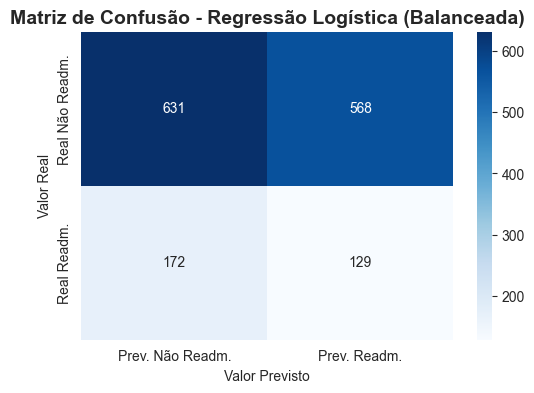

In [43]:
log_reg_balanced_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

log_reg_balanced_pipeline.fit(X_train, y_train)
y_pred_balanced = log_reg_balanced_pipeline.predict(X_test)

print(f"\nAcurácia (Balanceada): {accuracy_score(y_test, y_pred_balanced):.4f}")
print("\nRelatório de Classificação (Balanceado):")
print(classification_report(y_test, y_pred_balanced, target_names=['Não Readmitido (0)', 'Readmitido (1)']))

cm_balanced = confusion_matrix(y_test, y_pred_balanced)
plt.figure(figsize=(6,4))
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Prev. Não Readm.', 'Prev. Readm.'], 
            yticklabels=['Real Não Readm.', 'Real Readm.'])
plt.title('Matriz de Confusão - Regressão Logística (Balanceada)', fontsize=14, weight='bold')
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.savefig('graficos/plot_10_confusion_matrix_balanced.png', bbox_inches='tight')
plt.show()

### 6.3.1 Interpretação do Modelo (Importância das Features)

Analisamos os coeficientes do modelo de Regressão Logística para entender *quais* features ele considerou mais importantes para prever a readmissão.


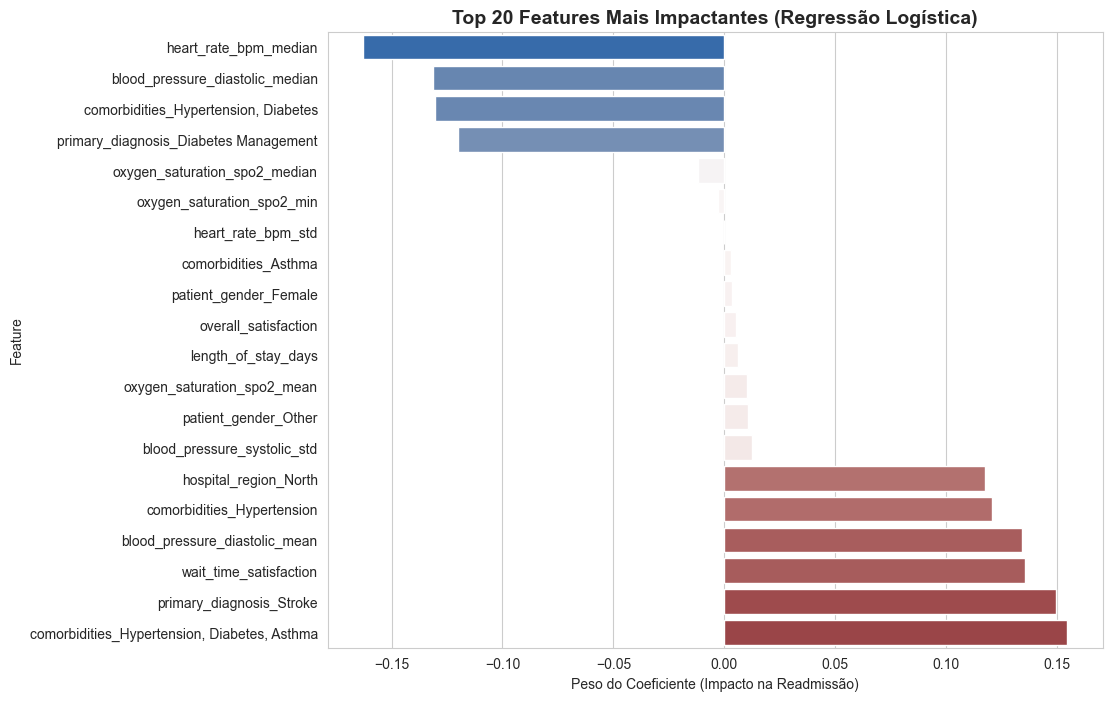

In [ ]:
# Obter pipelines e modelo
preprocessor_pipeline = log_reg_balanced_pipeline.named_steps['preprocessor']
ohe_pipeline = preprocessor_pipeline.named_transformers_['cat'].named_steps['onehot']
logistic_model = log_reg_balanced_pipeline.named_steps['classifier']

# Obter nomes das features categóricas
try:
    cat_feature_names = ohe_pipeline.get_feature_names_out(categorical_features)
except Exception:
    cat_feature_names = ohe_pipeline.get_feature_names(categorical_features)

all_feature_names = numeric_features + list(cat_feature_names)

# Criar DataFrame de Coeficientes
coefficients = pd.DataFrame(
    data=logistic_model.coef_[0],
    index=all_feature_names,
    columns=['Coeficiente']
)

coefficients['Coef_Absoluto'] = coefficients['Coeficiente'].abs()
coefficients = coefficients.sort_values(by='Coef_Absoluto', ascending=False)

# Plotar os 10 mais positivos e 10 mais negativos
top_n = 10
top_features = pd.concat([coefficients.head(top_n), coefficients.tail(top_n)]).sort_values(by='Coeficiente')

plt.figure(figsize=(10, 8))
sns.barplot(x=top_features['Coeficiente'], y=top_features.index, hue=top_features['Coeficiente'], palette='vlag',legend=False)
plt.title(f'Top {top_n*2} Features Mais Impactantes (Regressão Logística)', fontsize=14, weight='bold')
plt.xlabel('Peso do Coeficiente (Impacto na Readmissão)')
plt.ylabel('Feature')
plt.savefig('graficos/plot_13_feature_importance_lr.png', bbox_inches='tight')
plt.show()

### 6.4 Modelo 2: Random Forest (com Balanceamento)

Testamos um modelo mais complexo, o Random Forest, também com `class_weight='balanced'`.

**Resultado (Similar à Falha):** O Random Forest, mesmo balanceado, também não conseguiu encontrar um padrão preditivo claro e obteve 80% de acurácia prevendo "Não Readmitido" para quase todos os pacientes.



Acurácia (Random Forest Balanceado): 0.7993

Relatório de Classificação (Random Forest Balanceado):
                    precision    recall  f1-score   support

Não Readmitido (0)       0.80      1.00      0.89      1199
    Readmitido (1)       0.00      0.00      0.00       301

          accuracy                           0.80      1500
         macro avg       0.40      0.50      0.44      1500
      weighted avg       0.64      0.80      0.71      1500



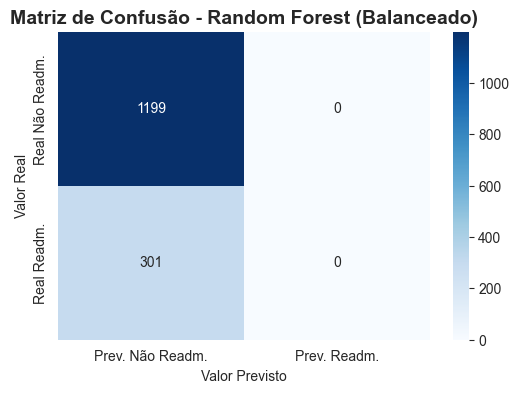

In [45]:
rf_balanced_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'))
])

rf_balanced_pipeline.fit(X_train, y_train)
y_pred_rf_balanced = rf_balanced_pipeline.predict(X_test)
accuracy_rf_balanced = accuracy_score(y_test, y_pred_rf_balanced)

print(f"\nAcurácia (Random Forest Balanceado): {accuracy_rf_balanced:.4f}")
print("\nRelatório de Classificação (Random Forest Balanceado):")
print(classification_report(y_test, y_pred_rf_balanced, target_names=['Não Readmitido (0)', 'Readmitido (1)'], zero_division=0))

cm_rf_balanced = confusion_matrix(y_test, y_pred_rf_balanced)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf_balanced, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Prev. Não Readm.', 'Prev. Readm.'], 
            yticklabels=['Real Não Readm.', 'Real Readm.'])
plt.title('Matriz de Confusão - Random Forest (Balanceado)', fontsize=14, weight='bold')
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.savefig('graficos/plot_11_confusion_matrix_rf_balanced.png', bbox_inches='tight')
plt.show()

## 7. Conclusão da Análise e Próximos Passos

### 7.1. O que os Dados Revelaram (Insights)

* **EDA (Análise Exploratória):** A análise foi bem-sucedida em gerar insights. Identificamos que pacientes mais velhos, com internações mais longas e diagnósticos de insuficiência cardíaca (`Heart Failure`) são os que mais aparecem nos dados de readmissão.
* **Modelagem Preditiva:** A modelagem revelou que, **com os dados atuais, o sinal preditivo para readmissão é muito fraco**. Os modelos (Regressão Logística e Random Forest) não conseguiram criar uma regra clara para separar pacientes de alto e baixo risco. A Regressão Logística balanceada foi o único modelo que tentou ativamente identificar a classe minoritária.

### 7.2. Próximos Passos

O fato de os modelos não terem tido um bom desempenho não é um fracasso, mas sim um *diagnóstico*: os dados que temos (diagnóstico primário, sinais vitais e satisfação) não são suficientes para prever este desfecho complexo.

Para melhorar o atendimento ao paciente na HealthCare Solutions, recomendaríamos:

1.  **Enriquecimento de Dados:** Coletar e incluir features mais robustas, como:
    * Histórico de internações (número de admissões nos últimos 6 meses).
    * Medicações prescritas na alta.
    * Resultados de exames laboratoriais (ex: nível de creatinina, sódio).
    * Informações sociais (ex: se o paciente mora sozinho).
2.  **Engenharia de Atributos:** Criar features mais complexas, como a *volatilidade* dos sinais vitais (quantas vezes a SpO2 caiu abaixo de 90%), em vez de apenas a média.
3.  **Foco na Satisfação:** Investigar o pico de notas "1" na pesquisa de satisfação. Embora não tenha previsto a *readmissão*, é um problema operacional claro que impacta a jornada do paciente.
